# Banking - Logistic Regression

Goal: Use the bank direct marketing dataset (banking.csv) to train a logistic regression predicting if a client will subscribe (1/0) to a term deposit (variable called ‘y’).

Methods: train model with k-fold cross-validation, L1- and L2-penalty or no penalty, use class_weight = ‘balanced’, as the dataset is unbalanced, plot the ROC curve as well as precision and recall with varying thresholds

The dataset is based on http://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The CSV I've used: https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV # for random search
from sklearn.model_selection import GridSearchCV # for grid search

import seaborn as sns

from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
bank_data = pd.read_csv('https://raw.githubusercontent.com/madmashup/targeted-marketing-predictive-engine/master/banking.csv', delimiter=",")

## Data description

In [3]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [4]:
bank_data.info() # there are no values missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp_var_rate      41188 non-null float64
cons_price_idx    41188 non-null float64
cons_conf_idx     41188 non-null float64
euribor3m         41188 non-null float64
nr_employed       41188 non-null float64
y                 41188 non-null int64
dtypes: float64(5), int64(6), object(10)
memory usag

## Check and remove correlated numeric features

Correlation in the independent variables is a problem for regression as it can decrease the precision if the model.

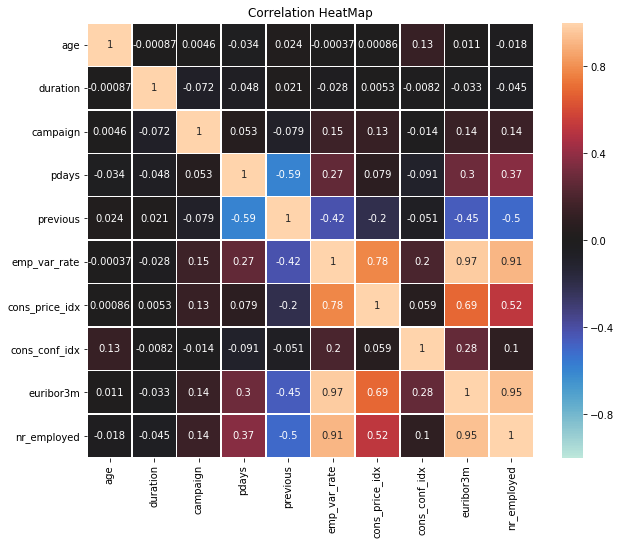

In [5]:
# creating pairwise correlation of columns using Pearson's
corr = bank_data.loc[:, bank_data.columns != 'y'].corr(method='pearson')

# plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, xticklabels=corr.columns,
            yticklabels=corr.columns, ax=ax, linewidths=.5,
            vmin=-1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

In [6]:
# loop to get the columns with highly correlated features

correlated_features = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > abs(0.85): # this number could be lower or higher, depending on the data and number of features
            colname = corr.columns[i]
            correlated_features.add(colname)
correlated_features

{'euribor3m', 'nr_employed'}

In [7]:
bank_data=bank_data.drop(columns=correlated_features)
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,1


## Separating X and y

In [0]:
# split table into X (features) and y (target)
y= bank_data["y"]
X=bank_data.drop(columns="y")

In [9]:
y_count=pd.DataFrame(y.value_counts()).reset_index()#.rename(columns=["outcome", "count"])
y_count=y_count.rename(columns={"index": "outcome", "y": "count"})
y_count

,outcome,count
0,0,36548
1,1,4640


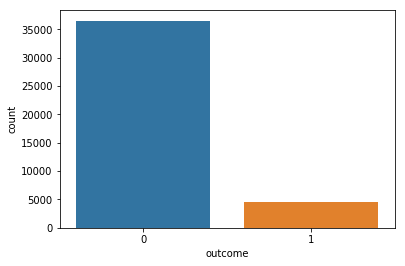

In [10]:
sns.barplot(data=y_count, x="outcome", y="count")
None

The graph above shows that outcome "1" (customer signed up) is far less common than outcome "0" (the customer didn't sign up). Therefore, y in this dataset is highly unbalanced. Further down I will apply SMOTE to balance the training set.

In [0]:
# divide X into columns with numerical values and categorical values
cat_cols = X.select_dtypes(include=['object']).columns
numer_cols = X.select_dtypes(include=['int', 'float']).columns

In [12]:
X[cat_cols].head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,nonexistent
1,technician,married,unknown,no,no,no,cellular,nov,fri,nonexistent
2,management,single,university.degree,no,yes,no,cellular,jun,thu,success
3,services,married,high.school,no,no,no,cellular,apr,fri,nonexistent
4,retired,married,basic.4y,no,yes,no,cellular,aug,fri,success


## One-hot encode categorical features

In [13]:
# OHE: This creates a binary column for each category and returns a sparse matrix or dense array.
ohe = OneHotEncoder()

# fit data
ohe.fit(X[cat_cols])

# show the generated categories
ohe.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single', 'unknown'], dtype=object),
 array(['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate',
        'professional.course', 'university.degree', 'unknown'],
       dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['no', 'unknown', 'yes'], dtype=object),
 array(['cellular', 'telephone'], dtype=object),
 array(['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct',
        'sep'], dtype=object),
 array(['fri', 'mon', 'thu', 'tue', 'wed'], dtype=object),
 array(['failure', 'nonexistent', 'success'], dtype=object)]

In [14]:
# transform data
tranform_data = ohe.transform(X[cat_cols]).toarray()
tranform_data # this array now only consist of 0/1, that is, the absence or presence of that particular categorical feature

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [15]:
# get descriptive titles for these new feature columns
transform_col_name = ohe.get_feature_names()
transform_col_name

array(['x0_admin.', 'x0_blue-collar', 'x0_entrepreneur', 'x0_housemaid',
       'x0_management', 'x0_retired', 'x0_self-employed', 'x0_services',
       'x0_student', 'x0_technician', 'x0_unemployed', 'x0_unknown',
       'x1_divorced', 'x1_married', 'x1_single', 'x1_unknown',
       'x2_basic.4y', 'x2_basic.6y', 'x2_basic.9y', 'x2_high.school',
       'x2_illiterate', 'x2_professional.course', 'x2_university.degree',
       'x2_unknown', 'x3_no', 'x3_unknown', 'x3_yes', 'x4_no',
       'x4_unknown', 'x4_yes', 'x5_no', 'x5_unknown', 'x5_yes',
       'x6_cellular', 'x6_telephone', 'x7_apr', 'x7_aug', 'x7_dec',
       'x7_jul', 'x7_jun', 'x7_mar', 'x7_may', 'x7_nov', 'x7_oct',
       'x7_sep', 'x8_fri', 'x8_mon', 'x8_thu', 'x8_tue', 'x8_wed',
       'x9_failure', 'x9_nonexistent', 'x9_success'], dtype=object)

In [0]:
trans_cat_df = pd.DataFrame(tranform_data, columns=transform_col_name) # put it back into a df

## Scale the numerical features

In [0]:
x_numer = X[numer_cols]

#Z score transformation by fixing the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_numer=scaler.fit_transform(x_numer)

In [18]:
x_numer = pd.DataFrame(x_numer, columns=numer_cols)

x_numer.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
0,0.381527,-0.186230,-0.565922,0.195414,-0.349494,0.839061,-0.227465,0.951267
1,1.245157,-0.463926,-0.565922,0.195414,-0.349494,-0.115781,-0.649003,-0.323542
2,-1.153816,0.311309,0.156105,-5.117342,3.691766,-1.134279,0.828107,0.151810
3,-0.098268,-0.282652,-0.204909,0.195414,-0.349494,-1.197935,-0.864955,-1.425496
4,1.437075,-0.467783,-0.565922,-5.133393,1.671136,-1.898153,-2.374889,1.966794


## Put the features back together

In [19]:
X = pd.concat([trans_cat_df, x_numer], axis=1)

X.info() # shows all the columns

X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 61 columns):
x0_admin.                 41188 non-null float64
x0_blue-collar            41188 non-null float64
x0_entrepreneur           41188 non-null float64
x0_housemaid              41188 non-null float64
x0_management             41188 non-null float64
x0_retired                41188 non-null float64
x0_self-employed          41188 non-null float64
x0_services               41188 non-null float64
x0_student                41188 non-null float64
x0_technician             41188 non-null float64
x0_unemployed             41188 non-null float64
x0_unknown                41188 non-null float64
x1_divorced               41188 non-null float64
x1_married                41188 non-null float64
x1_single                 41188 non-null float64
x1_unknown                41188 non-null float64
x2_basic.4y               41188 non-null float64
x2_basic.6y               41188 non-null float64
x2_basic.

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,x0_unemployed,x0_unknown,x1_divorced,x1_married,x1_single,x1_unknown,x2_basic.4y,x2_basic.6y,x2_basic.9y,x2_high.school,x2_illiterate,x2_professional.course,x2_university.degree,x2_unknown,x3_no,x3_unknown,x3_yes,x4_no,x4_unknown,x4_yes,x5_no,x5_unknown,x5_yes,x6_cellular,x6_telephone,x7_apr,x7_aug,x7_dec,x7_jul,x7_jun,x7_mar,x7_may,x7_nov,x7_oct,x7_sep,x8_fri,x8_mon,x8_thu,x8_tue,x8_wed,x9_failure,x9_nonexistent,x9_success,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.381527,-0.186230,-0.565922,0.195414,-0.349494,0.839061,-0.227465,0.951267
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.245157,-0.463926,-0.565922,0.195414,-0.349494,-0.115781,-0.649003,-0.323542
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.153816,0.311309,0.156105,-5.117342,3.691766,-1.134279,0.828107,0.151810
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.098268,-0.282652,-0.204909,0.195414,-0.349494,-1.197935,-0.864955,-1.425496
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.437075,-0.467783,-0.565922,-5.133393,1.671136,-1.898153,-2.374889,1.966794


## Train, val, test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
# further divide to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## Oversample with Synthetic Minority Oversampling Technique (SMOTE)

In [0]:
# resample training set with SMOTE to balance it
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [23]:
print(sorted(Counter(y_train).items()))

[(0, 23364), (1, 23364)]


In [24]:
print("X_train: " + str(len(X_train)))
print("X_val: " + str(len(X_val)))
print("X_test: " + str(len(X_test)))

X_train: 46728
X_val: 6590
X_test: 8238


## Find ideal parameters for model

### Random search 

In [0]:
# the random search is done with little or no prior knowledge about the best parameters
logreg = LogisticRegression(random_state=42, class_weight = "balanced") # initiate model; class_weight="balanced" is needed for unbalanced datasets

param_grid_random = {
    'penalty': ["l1", "l2"],
    'tol': [1e-6,1e-5,1e-4,1e-3],
    'C': [0.1,0.3,0.5,0.7,1,1.2,1.5, 1.8,2],
    'solver': ["liblinear"],
    'max_iter': [80,100, 150]
}

In [26]:
logreg_rs = RandomizedSearchCV(logreg, param_grid_random, n_iter=100, cv=5, scoring="roc_auc")
logreg_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='warn', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='warn', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'C': [0.1, 0.3, 0.5, 0.7, 1, 1.2, 1.5,
                                              1.8, 2],
                                        'max_iter': [80, 100, 150],
                                        'penalty': ['l1', 'l2'],


In [27]:
# Checking for best parameters
logreg_rs.best_params_

{'C': 0.1,
 'max_iter': 150,
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.001}

In [28]:
# Best Model RandomSearch
# Applying best model
logreg_rs.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)

In [29]:
# Evaluate RandomSearch model
scores_rs = cross_val_score(logreg_rs.best_estimator_,
                            X_train, y_train, cv=5, scoring='roc_auc')
scores_rs.mean()

0.9419121666972151

###Grid search

In [0]:
# grid search is a more targeted search for parameters, based on the preliminary findngs from random search
logreg = LogisticRegression(random_state=42, class_weight = "balanced") # initiate model; class_weight="balanced" is needed for unbalanced datasets

param_grid_grid = {
    'penalty': ["l1", "l2"],
    'tol': [1e-5,5e-5, 1e-4, 1e-3],
    'C': [0.05,0.1,0.2,0.3,0.4],
    'solver': ["liblinear"],
    'max_iter': [120,150, 170]
}

In [35]:
# Build Grid Search model
logreg_gs = GridSearchCV(logreg, param_grid_grid, cv=5, scoring='roc_auc', n_jobs=-1)
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.05, 0.1, 0.2, 0.3, 0.4],
                         'max_iter': [120, 150, 170], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear'],
                         'tol': [1e-05, 5e-05, 0.0001, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [36]:
# Checking for best parameters
logreg_gs.best_params_

{'C': 0.1,
 'max_iter': 120,
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.001}

In [37]:
# Best Model GridSearch
# Applying best model
logreg_gs.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=120, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)

In [38]:
# Evaluate GridSearch model
scores_logreg_gs = cross_val_score(logreg_gs.best_estimator_,
                            X_train, y_train, cv=5, scoring='roc_auc')
scores_logreg_gs.mean()

0.9419121666972151

## Optimized LogReg model

In [39]:
# this is the same model as found above after grid search
logreg = logreg_gs.best_estimator_.fit(X_train, y_train)

logreg_scores = cross_val_score(
    logreg, X_train, y_train, cv=5, scoring='roc_auc')
print("5-fold cross validation score: " + str(logreg_scores.mean()))

5-fold cross validation score: 0.9419121666972151


## Predictions on the validation set

In [40]:
# predictions on validation set
predictions = logreg.predict(X_val)
predictions_prob = logreg.predict_proba(X_val)

logreg.score(X_val, y_val)

0.8669195751138088

In [0]:
df = pd.DataFrame([np.array(y_val), predictions])

In [42]:
np.array([np.array(y_val), predictions]).reshape(-1,2)

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 0]])

In [43]:
df = pd.DataFrame(np.array([np.array(y_val), predictions]).reshape(-1,2)) # y test data into DF
df.columns = ['y','pred_y'] # Rename columns
df.head(20)

print("Sum all true y=1: " + str(sum(df["y"])))
print("Sum all predicted y=1: " + str(sum(df["pred_y"])))

Sum all true y=1: 1100
Sum all predicted y=1: 1063


### Performance 

In [44]:
# create a confusion matrix
# TN | FP
# FN | TP

from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, predictions)

array([[5070,  789],
       [  88,  643]])

In [45]:
# get the metrics for the classifications
from sklearn.metrics import classification_report

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      5859
           1       0.45      0.88      0.59       731

    accuracy                           0.87      6590
   macro avg       0.72      0.87      0.76      6590
weighted avg       0.92      0.87      0.88      6590



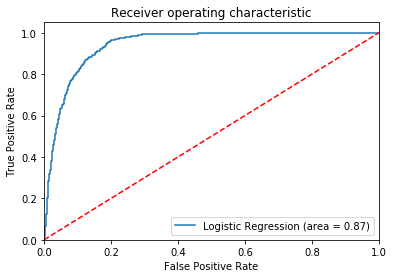

In [46]:
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_val, logreg.predict(X_val))
fpr, tpr, thresholds = roc_curve(
    y_val, logreg.predict_proba(X_val)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

The model seems to be quite good. Should even better predictions be needed, the model could be further adjusted. However, for now this looks close enough and I will do the final predictions on the test set.

## Predictions on the test set

In [47]:
# predictions on validation set
predictions = logreg.predict(X_test)
predictions_prob = logreg.predict_proba(X_test)

logreg.score(X_test, y_test)

0.8591891235736829

In [48]:
df = pd.DataFrame([np.array(y_test), predictions])
np.array([np.array(y_test), predictions]).reshape(-1,2)

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [49]:
df = pd.DataFrame(np.array([np.array(y_test), predictions]).reshape(-1,2)) # y test data into DF
df.columns = ['y','pred_y'] # Rename columns
df.head(20)

print("Sum all true y=1: " + str(sum(df["y"])))
print("Sum all predicted y=1: " + str(sum(df["pred_y"])))

Sum all true y=1: 1350
Sum all predicted y=1: 1388


### Performance

In [50]:
# create a confusion matrix
# TN | FP
# FN | TP

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[6289, 1036],
       [ 124,  789]])

In [51]:
# get the metrics for the classifications

from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7325
           1       0.43      0.86      0.58       913

    accuracy                           0.86      8238
   macro avg       0.71      0.86      0.75      8238
weighted avg       0.92      0.86      0.88      8238



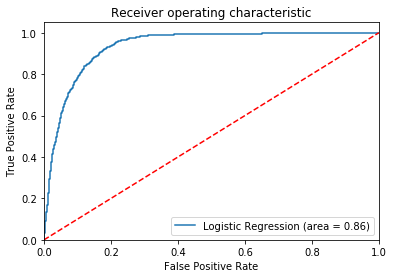

In [52]:
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(
    y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

## Conclusion

The logistic regression model can be used to predict whether a customer will sign up for the service or not. It performs quite well on the validation and test data after being trained on SMOTE resampled data.

More detailed feature selection could be used to further improve the predictive power of the model.